In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

# 线性模型实战

## 采样数据

为了能够很好地模拟真实样本的观测误差，我们给模型添加误差自变量$\epsilon$，它采样自均 值为 0，方差为 0.01 的高斯分布：

\begin{equation}
𝑦=1.477x+0.089+\epsilon,\epsilon\sim\mathcal{N}(0,0.01)
\end{equation}

In [1]:
import numpy as np
data=[]
for i in range(100):
    x=np.random.uniform(-10,10)
    eps=np.random.normal(0,0.1)
    y=1.477*x+0.089+eps
    data.append([x,y])
data=np.array(data)

定义误差函数：
$$
\mathcal{L}=\sum_{i=0}^{n}(wx^{(i)}+b-y^{(i)})^2
$$

In [2]:
def mse(b,w,points):
    totalError=0
    for i in range(0,len(points)):
        x=points[i,0]
        y=points[i,1]
        totalError=totalError+(y-(w*x+b))**2
    return totalError/float(len(points))

计算偏导数$$
\frac{\partial{\mathcal{L}}}{\partial{w}} \quad\frac{\partial{\mathcal{L}}}{\partial{b}}
$$

In [3]:
def step_gradient(b_current,w_current,points,lr):
    b_gradient=0
    w_gradient=0
    M=float(len(points))
    for i in range(0,len(points)):
        x=points[i,0]
        y=points[i,1]
        # 误差函数对 b 的导数：grad_b = 2(wx+b-y)，
        b_gradient=b_gradient+(2/M)*((w_current*x+b_current)-y)
        w_gradient=w_gradient+(2/M)*x*((w_current*x+b_current)-y)
    new_b=b_current-(lr*b_gradient)
    new_w=w_current-(lr*w_gradient)
    return(new_b,new_w)

计算出误差函数在w和b处的梯度后，我们可以更新w和b的取值，我们把对数据集的所有样本训练一次称为一个Epoch，共循环迭代num_iterations个Epoch

In [4]:
def gradient_descent(points,starting_b,starting_w,lr,num_iterations):
    b=starting_b
    w=starting_w
    for step in range(num_iterations):
        b,w=step_gradient(b,w,np.array(points),lr)
        loss=mse(b,w,points)#计算当前的均方误差，监控训练进度
        if step%50==0:#打印误差和实时的w,b值
            print(f"iteration:{step},loss:{loss},w:{w},b:{b}")
    return [b,w]#返回最后一次的w,b

定义主训练函数：

In [5]:
lr=0.01
initial_b=0
initial_w=0
num_iterations=1000
[b,w]=gradient_descent(data,initial_b,initial_w,lr,num_iterations)
loss=mse(b,w,data)
print(f'Final loss:{loss},w:{w},b:{b}')

iteration:0,loss:5.582514830509888,w:1.0899745412140727,b:0.016216730381409184
iteration:50,loss:0.009282539530900975,w:1.4779034358745997,b:0.07295500223058995
iteration:100,loss:0.008517190788099734,w:1.4776509317213995,b:0.09184908751576783
iteration:150,loss:0.008414355324518511,w:1.4775583745030108,b:0.09877485073918538
iteration:200,loss:0.00840053792079317,w:1.4775244469870976,b:0.10131353919659762
iteration:250,loss:0.00839868135653936,w:1.477512010611458,b:0.10224411375941353
iteration:300,loss:0.008398431900787984,w:1.4775074519682776,b:0.10258522257661858
iteration:350,loss:0.00839839838286811,w:1.4775057809647434,b:0.10271025847360557
iteration:400,loss:0.008398393879259971,w:1.4775051684463467,b:0.1027560912833918
iteration:450,loss:0.008398393274136296,w:1.477504943923311,b:0.10277289163036028
iteration:500,loss:0.008398393192829345,w:1.477504861622773,b:0.10277904991870393
iteration:550,loss:0.008398393181904612,w:1.4775048314549173,b:0.10278130728370914
iteration:600,lo

和最小二乘法相比，结果极其相近

In [6]:
np.polyfit(data[:,0],data[:,1],1)

array([1.47750481, 0.10278261])

# 分类问题

这里使用mnist数据集来测试

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers,datasets

(x,y),(x_val,y_val)=datasets.mnist.load_data('C:\\Users\\xr chen\\Downloads\\mnist.npz')
x=2*tf.convert_to_tensor(x,dtype=tf.float32)/255-1
y=tf.convert_to_tensor(y,dtype=tf.int32)
y=tf.one_hot(y,depth=10)
print(x.shape,y.shape)
train_dataset=tf.data.Dataset.from_tensor_slices((x,y))#构建数据集对象
train_dataset=train_dataset.batch(512)#批量训练

(60000, 28, 28) (60000, 10)


load_data()函数返回两个元组(tuple)对象，第一个是训练集，第二个是测试集，每个 tuple 的第一个元素是多个训练图片数据X，第二个元素是训练图片对应的类别数字Y。其中训练集X的大小为(60000,28,28)，代表了 60000 个样本，每个样本由 28 行、28 列构成。

从 TensorFlow 中加载的 MNIST 数据图片，数值的范围在[0,255]之间。在机器学习中 间，一般希望数据的范围在 0 周围小范围内分布。通过预处理步骤，我们把[0,255]像素范 围归一化(Normalize)到[0,1.]区间，再缩放到[−1,1]区间，从而有利于模型的训练

如果物体属 于第𝑖类的话，那么索引为𝑖的位置上设置为 1，其他位置设置为 0，我们把这种编码方式叫 做 one-hot 编码(独热编码)

One-hot 编码是非常稀疏 (Sparse)的，相对于数字编码来说，占用较多的存储空间，所以一般在存储时还是采用数字 编码，在计算时，根据需要来把数字编码转换成 One-hot 编码

In [3]:
y=tf.constant([0,1,2,3])
y=tf.one_hot(y,depth=10)
print(y)

tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]], shape=(4, 10), dtype=float32)


# 非线性模型

线性模型表达能力偏弱，我们可以给线性模型嵌套一个线性函数。我们把这个非线性函数称为激活函数，用$\sigma$表示：
$$
\bf{o}=\sigma(\bf{Wx}+\bf{b})
$$

常见的具体的非线性激活函数，比如Sigmoid函数或者ReLU函数，ReLU函数非常简单，仅仅是在y=x的基础上面截去了x<0的部分，仅仅保留正的输入部分，清零负的输入。虽然简单，却有优良的非线性特性，梯度计算简单，这里通过嵌套ReLU函数将模型转化为非线性模型：
$$
{\bf{o}}=ReLU({\bf{Wx}+\bf{b}})
$$

## 表达能力

针对模型的表达能力偏弱的问题，我们可以重复堆叠多次变换增加表达能力
$$
{\bf{h_1}}=ReLU({\bf{W_1x}+\bf{b_1}})\\
{\bf{h_2}}=ReLU({\bf{W_2h_1}+\bf{b_2}})\\
{\bf{o}}={\bf{W_3h_2}+\bf{b_3}}
$$
把第一层神经元的输出作为第二层神经元的输入，最后一层神经元的输出作为模型的输出${\bf{o}}$

由于手动计算导数复杂，因此需要借助自动求导技术

## 网络搭建

 对于第一层模型来说，他接受的输入${\bf{x}}\in R^{784}$$(28\cdot28=784)$，输出${\bf{h_1}} \in R^{256}$设计为长度为 256 的向量，我们不需要显式地编写${\bf{𝒉_𝟏}} = ReLU({\bf{𝑾_𝟏𝒙}}+ {\bf{𝒃_𝟏}})$的计算逻辑，在 TensorFlow 中通过 一行代码即可实现

In [5]:
layers.Dense(256,activation='relu')

对于3层的网络我们可以通过快速完成3层网络的搭建，第1层输出节点256，第二层输出节点128，输出层输出10

In [2]:
model=keras.Sequential([
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(10)#和上面的表达式对应，所以第三层网络没有relu，所以有负值的输出
])

## 模型训练

得到模型输出$\sigma$后，通过MSE损失函数计算当前的误差$\mathcal{L}$

In [48]:
with tf.GradientTape() as tape:#构建梯度记录环境
    #打平,[b,28,28]-->[b,784]
    x=tf.reshape(x,(-1,28*28))
    #Step1.得到模型输出Output
    #[b,784]->[b,10]
    out=model(x)
    loss=tf.reduce_sum(tf.square(out-y))/x.shape[0]

再利用 TensorFlow 提供的自动求导函数tape.gradient(loss,model.trainable_variables)求出模 型中所有的梯度信息
$$
\frac{\partial{\mathcal{L}}}{\partial{\theta}},\theta\in\{W_1,b_1,W_2,b_2,W_3,b_3\}
$$

In [49]:
#Step3.计算参数的梯度
grads=tape.gradient(loss,model.trainable_variables)
#w'=w-lr*grad,更新参数网络
optimizer=optimizers.SGD(learning_rate=0.001)
optimizer.apply_gradients(zip(grads,model.trainable_variables))
print(loss.numpy())

2.2047849


In [3]:
def train_epoch(epoch):
    # Step4.loop
    for step, (x, y) in enumerate(train_dataset):
        with tf.GradientTape() as tape:#构建梯度记录环境
            #打平,[b,28,28]-->[b,784]
            x=tf.reshape(x,(-1,28*28))
            #Step1.得到模型输出Output
            #[b,784]->[b,10]
            out=model(x)
            loss=tf.reduce_sum(tf.square(out-y))/x.shape[0]
        # w' = w - lr * grad
        grads=tape.gradient(loss,model.trainable_variables)
        #w'=w-lr*grad,更新参数网络
        optimizer=optimizers.SGD(learning_rate=0.001)
        optimizer.apply_gradients(zip(grads,model.trainable_variables))
        if step % 100 == 0:
            print(epoch, step, 'loss:', loss.numpy())

In [4]:
def train():
    for epoch in range(60):
        train_epoch(epoch)

In [5]:
train()

0 0 loss: 5.1850233
0 100 loss: 1.0177236
1 0 loss: 0.9137496
1 100 loss: 0.7905963
2 0 loss: 0.7397393
2 100 loss: 0.69073355
3 0 loss: 0.65821636
3 100 loss: 0.63227177
4 0 loss: 0.6076087
4 100 loss: 0.59161043
5 0 loss: 0.5717077
5 100 loss: 0.5607679
6 0 loss: 0.54404736
6 100 loss: 0.53585154
7 0 loss: 0.52118975
7 100 loss: 0.51502055
8 0 loss: 0.50194556
8 100 loss: 0.4973259
9 0 loss: 0.4851991
9 100 loss: 0.48177868
10 0 loss: 0.4705286
10 100 loss: 0.46769357
11 0 loss: 0.45751068
11 100 loss: 0.45512518
12 0 loss: 0.44585454
12 100 loss: 0.44370478
13 0 loss: 0.4354513
13 100 loss: 0.43330032
14 0 loss: 0.42601967
14 100 loss: 0.42374143
15 0 loss: 0.4175372
15 100 loss: 0.41496474
16 0 loss: 0.4096306
16 100 loss: 0.40688446
17 0 loss: 0.4021516
17 100 loss: 0.39937186
18 0 loss: 0.39511353
18 100 loss: 0.3924002
19 0 loss: 0.3885798
19 100 loss: 0.38590145
20 0 loss: 0.38240317
20 100 loss: 0.37980312
21 0 loss: 0.37662542
21 100 loss: 0.37409207
22 0 loss: 0.37125897
22 

tf.Tensor(
[[ 0.01827951 -0.12186617  0.7284543   0.09377631  0.02286693  0.06474251
   0.07318782 -0.06055652 -0.00634248 -0.09883674]], shape=(1, 10), dtype=float32)
tf.Tensor([2], shape=(1,), dtype=int64)


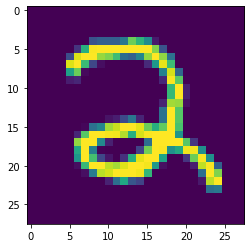

In [7]:
import matplotlib.pyplot as plt

x_valt=2*tf.convert_to_tensor(x_val,dtype=tf.float32)/255-1
testx=tf.reshape(x_valt[731],(-1,28*28))
result=model(testx)
print(result)
print(tf.argmax(result,axis=1))
imag=x_val[731]
plt.imshow(imag)
plt.show()

# TensorFlow 基础

## 数值类型

In [2]:
import tensorflow as tf

a=1.2
aa=tf.constant(1.2)
type(a),type(aa),tf.is_tensor(aa)

(float, tensorflow.python.framework.ops.EagerTensor, True)

In [4]:
x=tf.constant([1,2.,3.3])
x

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1. , 2. , 3.3], dtype=float32)>

为了方便导出数据和其他的系统模块，使用numpy()方法

In [5]:
x.numpy()

array([1. , 2. , 3.3], dtype=float32)

与标量不同，向量的定义需通过List类型传给tf.constant()

In [6]:
a=tf.constant([1.2])
a,a.shape

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.2], dtype=float32)>,
 TensorShape([1]))

定义矩阵时

In [8]:
a=tf.constant([[1,2],[3,4]])
a,a.shape

(<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[1, 2],
        [3, 4]])>,
 TensorShape([2, 2]))

3维的张量可以定义为

In [11]:
a=tf.constant([[[1,2],[3,4]],[[5,6],[7,8]]])
a,a.shape

(<tf.Tensor: shape=(2, 2, 2), dtype=int32, numpy=
 array([[[1, 2],
         [3, 4]],
 
        [[5, 6],
         [7, 8]]])>,
 TensorShape([2, 2, 2]))

## 字符串布尔型

In [13]:
a=tf.constant('Hello,Deep Learning.')
a

<tf.Tensor: shape=(), dtype=string, numpy=b'Hello,Deep Learning.'>

In [14]:
tf.strings.lower(a)

<tf.Tensor: shape=(), dtype=string, numpy=b'hello,deep learning.'>

In [15]:
a=tf.constant(True)
a

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [16]:
a=tf.constant([True,False])
a

<tf.Tensor: shape=(2,), dtype=bool, numpy=array([ True, False])>

需要注意TensorFlow的布尔类型和python语言的布尔类型不对等：(但是测试结果好像ok)

In [21]:
a=tf.constant(True)
print(a==True)

tf.Tensor(True, shape=(), dtype=bool)


## 数值精度

In [23]:
print(tf.constant(123456789,dtype=tf.int16))
tf.constant(123456789,dtype=tf.int32)

tf.Tensor(-13035, shape=(), dtype=int16)


<tf.Tensor: shape=(), dtype=int32, numpy=123456789>

保存精度过低时，数据发生了溢出，得到了错误的结果

In [26]:
import numpy as np
print(np.pi)
tf.constant(np.pi,dtype=tf.float32)

3.141592653589793


<tf.Tensor: shape=(), dtype=float32, numpy=3.1415927>

可以采用tf.float64来保存$\pi$能获得更高的精度

In [28]:
tf.constant(np.pi,dtype=tf.float64)

<tf.Tensor: shape=(), dtype=float64, numpy=3.141592653589793>

## 读取精度

In [31]:
print('before:',a.dtype)
if a.dtype!=tf.float32:
    a=tf.cast(a,tf.float32)
print('after:',a.dtype)

before: <dtype: 'bool'>
after: <dtype: 'float32'>


## 类型转换

In [32]:
a=tf.constant(np.pi,dtype=tf.float16)
tf.cast(a,tf.double)

<tf.Tensor: shape=(), dtype=float64, numpy=3.140625>

高精度向低精度转化时可能发生数据溢出隐患

In [33]:
a=tf.constant(123456789,dtype=tf.int32)
tf.cast(a,tf.int16)

<tf.Tensor: shape=(), dtype=int16, numpy=-13035>

布尔型和整形之间也可以互相转换

In [34]:
a=tf.constant([True,False])
tf.cast(a,tf.int32)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 0])>

In [36]:
a=tf.constant([-1,0,1,2])
tf.cast(a,tf.bool)

<tf.Tensor: shape=(4,), dtype=bool, numpy=array([ True, False,  True,  True])>

# TensorFlow常用函数

tf.Variable可以将普通的张量转化为待优化的张量，从而可以跟踪相关梯度信息

In [37]:
a=tf.constant([-1,0,1,2])
aa=tf.Variable(a)
aa.name,aa.trainable

('Variable:0', True)

也可以直接使用Variable来创建张量

In [45]:
a=tf.Variable([[1,2],[3,4]])
a

<tf.Variable 'Variable:0' shape=(2, 2) dtype=int32, numpy=
array([[1, 2],
       [3, 4]])>

## 数据集构建

一般来说，我们需要把数据的特征和标签一一配对后喂入网络

In [46]:
features=tf.constant([12,23,10,17])
labels=tf.constant([0,1,1,0])
dataset=tf.data.Dataset.from_tensor_slices((features,labels))
print(dataset)
for element in dataset:
    print(element)

<TensorSliceDataset shapes: ((), ()), types: (tf.int32, tf.int32)>
(<tf.Tensor: shape=(), dtype=int32, numpy=12>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)
(<tf.Tensor: shape=(), dtype=int32, numpy=23>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
(<tf.Tensor: shape=(), dtype=int32, numpy=10>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
(<tf.Tensor: shape=(), dtype=int32, numpy=17>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)


## 对参数求导数

In [50]:
with tf.GradientTape() as tape:
    w=tf.Variable(tf.constant(3.0))
    loss=tf.pow(w,2)
grad=tape.gradient(loss,w)
print(grad)

tf.Tensor(6.0, shape=(), dtype=float32)


enumerate常在for循环中使用：

In [51]:
seq=['one','two','three']
for i,element in enumerate(seq):
    print(i,element)

0 one
1 two
2 three


## one-hot encoding

分类问题中，常用独热码做标签，1表示是，0表示不是，取值$[0,1]$之间可以表示是的概率是多少

用tf.one_hot函数可以把待转换的数据转化为one-hot形式的数据输出格式为

tf.one_hot(带转化数据，depth=几分类)

In [54]:
classes=3
labels=tf.constant([1,0,2])
output=tf.one_hot(labels,depth=classes)
print(output)

tf.Tensor(
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]], shape=(3, 3), dtype=float32)


一般来说，需要通过变化来表示属于某一类的概率，变换公式如下，使n个分类的n个输出符合概率分布
$$
Softmax(y_i)=\frac{e^{y_i}}{\sum_{j=0}^ne^{y_i}}\\
\forall x, P(X=x)\in[0,1]\quad\sum_xP(X=x)=1
$$

In [55]:
y=tf.constant([1.01,2.01,-0.66])
y_pro=tf.nn.softmax(y)
print('After softmax,y_pro is',y_pro)

After softmax,y_pro is tf.Tensor([0.25598174 0.69583046 0.04818781], shape=(3,), dtype=float32)


## 参数自更新

更新参数的值并返回，但先用tf.Variable定义变量为可训练，下面是自减的例子

In [56]:
w=tf.Variable(4)
w.assign_sub(1)
print(w)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=3>


## 张量最大值索引号

In [3]:
import numpy as np

test=np.array([[1,2,3],[2,3,4],[5,4,3],[8,7,2]])
print(test)
print(tf.argmax(test,axis=0))
print(tf.argmax(test,axis=1))

[[1 2 3]
 [2 3 4]
 [5 4 3]
 [8 7 2]]
tf.Tensor([3 3 1], shape=(3,), dtype=int64)
tf.Tensor([2 2 0 0], shape=(4,), dtype=int64)


## 鸢尾花数据集的导入

In [2]:
from sklearn import datasets
from pandas import DataFrame
import pandas as pd
import numpy as np

x_data=datasets.load_iris().data
y_data=datasets.load_iris().target
#为了让数据更好看我们采用pandas进行整理
x_data=DataFrame(x_data,columns=['花萼长度','花儿宽度','花瓣长度','花瓣宽度'])
pd.set_option('display.unicode.east_asian_width',True)#设置列名对齐
print('x_data_add_index: \n',x_data)

x_data_add_index: 
      花萼长度  花儿宽度  花瓣长度  花瓣宽度
0         5.1       3.5       1.4       0.2
1         4.9       3.0       1.4       0.2
2         4.7       3.2       1.3       0.2
3         4.6       3.1       1.5       0.2
4         5.0       3.6       1.4       0.2
..        ...       ...       ...       ...
145       6.7       3.0       5.2       2.3
146       6.3       2.5       5.0       1.9
147       6.5       3.0       5.2       2.0
148       6.2       3.4       5.4       2.3
149       5.9       3.0       5.1       1.8

[150 rows x 4 columns]


In [3]:
x_data['类别']=y_data
print('x_data add a column:\n',x_data)

x_data add a column:
      花萼长度  花儿宽度  花瓣长度  花瓣宽度  类别
0         5.1       3.5       1.4       0.2     0
1         4.9       3.0       1.4       0.2     0
2         4.7       3.2       1.3       0.2     0
3         4.6       3.1       1.5       0.2     0
4         5.0       3.6       1.4       0.2     0
..        ...       ...       ...       ...   ...
145       6.7       3.0       5.2       2.3     2
146       6.3       2.5       5.0       1.9     2
147       6.5       3.0       5.2       2.0     2
148       6.2       3.4       5.4       2.3     2
149       5.9       3.0       5.1       1.8     2

[150 rows x 5 columns]


## 鸢尾花分类

加载数据集，打乱并分为训练集和测试集

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

x_data=datasets.load_iris().data
y_data=datasets.load_iris().target
#打乱数据集
np.random.seed(116)
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)
#数据集分为训练集和测试集
x_train=x_data[:-30]
y_train=y_data[:-30]
x_test=x_data[-30:]
y_test=y_data[-30:]

配对成输入特征和标签对之前，先对数据类型进行转换，避免因为矩阵相乘时数据类型不一致报错,打包（batch），每次喂入一个batch

In [2]:
x_train=tf.cast(x_train,tf.float32)
x_test=tf.cast(x_test,tf.float32)
train_db=tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32)
test_db=tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32)

我们采用一层的神经网络(输入4个特征，输出四种花)，并定义其中所有的可训练参数

In [3]:
w1=tf.Variable(tf.random.truncated_normal([4,3],stddev=0.1,seed=1))
b1=tf.Variable(tf.random.truncated_normal([3],stddev=0.1,seed=1))

定义学习率，记录loss和acc（准确率）使用的list，epoch，loss_all记录四个step生成的4个loss的和（128/batch）

In [4]:
lr=0.1
train_loss_results=[]
test_acc=[]
epoch=500
loss_all=0

下面开始训练

In [10]:
for epoch in range(epoch):
    for step,(x_train,y_train)in enumerate(train_db):
        with tf.GradientTape()as tape:
            y=tf.matmul(x_train,w1)+b1
            y=tf.nn.softmax(y)
            y_=tf.one_hot(y_train,depth=3)#标签转化为one-hot编码可以和softmax的概率值相减求loss#求均方误差
            loss=tf.reduce_mean(tf.square(y_-y))#求均方误差
            loss_all=loss_all+loss.numpy()
        grads=tape.gradient(loss,[w1,b1])
        #梯度下降更新参数
        w1.assign_sub(lr*grads[0])
        b1.assign_sub(lr*grads[1])
    print('Epoch {}, loss:{}'.format(epoch,loss_all/4))#平均每个step的误差
    train_loss_results.append(loss_all/4)
    loss_all=0#loss_all归零为下一个epoch的loss做准备
    
    #计算准确率
    total_correct,total_number=0,0
    for x_test,y_test in test_db:
        y=tf.matmul(x_test,w1)+b1
        y=tf.nn.softmax(y)
        pred=tf.argmax(y,axis=1)
        pred=tf.cast(pred,dtype=y_test.dtype)
        correct=tf.cast(tf.equal(pred,y_test),dtype=tf.int32)
        correct=tf.reduce_sum(correct)
        total_correct+=int(correct)
        total_number+=x_test.shape[0]
    acc=total_correct/total_number
    test_acc.append(acc)
    print('Test.acc:',acc)
    print('---------------------------------------')


Epoch 0, loss:0.022661410504952073
Test.acc: 0.9666666666666667
---------------------------------------
Epoch 1, loss:0.022657548310235143
Test.acc: 0.9666666666666667
---------------------------------------
Epoch 2, loss:0.02265369798988104
Test.acc: 0.9666666666666667
---------------------------------------
Epoch 3, loss:0.022649836027994752
Test.acc: 0.9666666666666667
---------------------------------------
Epoch 4, loss:0.022646001307293773
Test.acc: 0.9666666666666667
---------------------------------------
Epoch 5, loss:0.022642147494480014
Test.acc: 0.9666666666666667
---------------------------------------
Epoch 6, loss:0.02263831067830324
Test.acc: 0.9666666666666667
---------------------------------------
Epoch 7, loss:0.02263447572477162
Test.acc: 0.9666666666666667
---------------------------------------
Epoch 8, loss:0.022630640072748065
Test.acc: 0.9666666666666667
---------------------------------------
Epoch 9, loss:0.022626824444159865
Test.acc: 0.9666666666666667
---

Epoch 89, loss:0.022333484143018723
Test.acc: 0.975
---------------------------------------
Epoch 90, loss:0.022329967003315687
Test.acc: 0.975
---------------------------------------
Epoch 91, loss:0.02232645731419325
Test.acc: 0.975
---------------------------------------
Epoch 92, loss:0.02232294948771596
Test.acc: 0.975
---------------------------------------
Epoch 93, loss:0.022319449577480555
Test.acc: 0.975
---------------------------------------
Epoch 94, loss:0.022315953392535448
Test.acc: 0.975
---------------------------------------
Epoch 95, loss:0.022312455344945192
Test.acc: 0.975
---------------------------------------
Epoch 96, loss:0.022308964282274246
Test.acc: 0.975
---------------------------------------
Epoch 97, loss:0.022305469727143645
Test.acc: 0.975
---------------------------------------
Epoch 98, loss:0.02230198634788394
Test.acc: 0.975
---------------------------------------
Epoch 99, loss:0.02229850529693067
Test.acc: 0.975
--------------------------------

Epoch 183, loss:0.02201801724731922
Test.acc: 0.975
---------------------------------------
Epoch 184, loss:0.022014812100678682
Test.acc: 0.975
---------------------------------------
Epoch 185, loss:0.022011621156707406
Test.acc: 0.975
---------------------------------------
Epoch 186, loss:0.022008419269695878
Test.acc: 0.975
---------------------------------------
Epoch 187, loss:0.02200522320345044
Test.acc: 0.975
---------------------------------------
Epoch 188, loss:0.02200203645043075
Test.acc: 0.975
---------------------------------------
Epoch 189, loss:0.021998848533257842
Test.acc: 0.975
---------------------------------------
Epoch 190, loss:0.02199565782211721
Test.acc: 0.975
---------------------------------------
Epoch 191, loss:0.021992476424202323
Test.acc: 0.975
---------------------------------------
Epoch 192, loss:0.021989301312714815
Test.acc: 0.975
---------------------------------------
Epoch 193, loss:0.02198612759821117
Test.acc: 0.975
----------------------

Epoch 274, loss:0.021738458424806595
Test.acc: 0.975
---------------------------------------
Epoch 275, loss:0.021735518239438534
Test.acc: 0.975
---------------------------------------
Epoch 276, loss:0.0217325733974576
Test.acc: 0.975
---------------------------------------
Epoch 277, loss:0.021729636006057262
Test.acc: 0.975
---------------------------------------
Epoch 278, loss:0.02172670396976173
Test.acc: 0.975
---------------------------------------
Epoch 279, loss:0.021723762853071094
Test.acc: 0.975
---------------------------------------
Epoch 280, loss:0.021720836171880364
Test.acc: 0.975
---------------------------------------
Epoch 281, loss:0.021717899711802602
Test.acc: 0.975
---------------------------------------
Epoch 282, loss:0.021714983973652124
Test.acc: 0.975
---------------------------------------
Epoch 283, loss:0.021712057292461395
Test.acc: 0.975
---------------------------------------
Epoch 284, loss:0.021709123859182
Test.acc: 0.975
-----------------------

Epoch 363, loss:0.021486292826011777
Test.acc: 0.975
---------------------------------------
Epoch 364, loss:0.021483566612005234
Test.acc: 0.975
---------------------------------------
Epoch 365, loss:0.02148083969950676
Test.acc: 0.975
---------------------------------------
Epoch 366, loss:0.021478121867403388
Test.acc: 0.975
---------------------------------------
Epoch 367, loss:0.02147540869191289
Test.acc: 0.975
---------------------------------------
Epoch 368, loss:0.021472694585099816
Test.acc: 0.975
---------------------------------------
Epoch 369, loss:0.021469969768077135
Test.acc: 0.975
---------------------------------------
Epoch 370, loss:0.021467271028086543
Test.acc: 0.975
---------------------------------------
Epoch 371, loss:0.0214645576197654
Test.acc: 0.975
---------------------------------------
Epoch 372, loss:0.02146184747107327
Test.acc: 0.975
---------------------------------------
Epoch 373, loss:0.021459147334098816
Test.acc: 0.975
----------------------

Test.acc: 0.975
---------------------------------------
Epoch 453, loss:0.021249890327453613
Test.acc: 0.975
---------------------------------------
Epoch 454, loss:0.021247357595711946
Test.acc: 0.975
---------------------------------------
Epoch 455, loss:0.02124483766965568
Test.acc: 0.975
---------------------------------------
Epoch 456, loss:0.02124231099151075
Test.acc: 0.975
---------------------------------------
Epoch 457, loss:0.0212397831492126
Test.acc: 0.975
---------------------------------------
Epoch 458, loss:0.021237262757495046
Test.acc: 0.975
---------------------------------------
Epoch 459, loss:0.02123473258689046
Test.acc: 0.975
---------------------------------------
Epoch 460, loss:0.021232223603874445
Test.acc: 0.975
---------------------------------------
Epoch 461, loss:0.02122970507480204
Test.acc: 0.975
---------------------------------------
Epoch 462, loss:0.021227189106866717
Test.acc: 0.975
---------------------------------------
Epoch 463, loss:0.02

最后一部分用来测试准确率，画图绘制loss和acc曲线

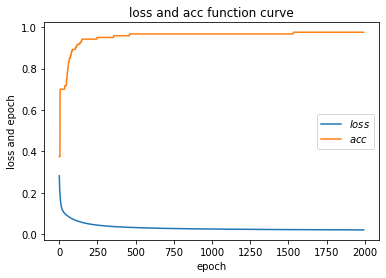

In [11]:
plt.title('loss and acc function curve')
plt.xlabel('epoch')
plt.ylabel('loss and epoch')
plt.plot(train_loss_results,label='$loss$')
plt.plot(test_acc,label='$acc$')
plt.legend()
plt.show()

# TensorFlow 函数扫盲

where函数如果条件是真返回A，条件是假返回B。tf.where(条件,A,B)

In [3]:
import tensorflow as tf

a=tf.constant([1,2,3,1,1])
b=tf.constant([0,1,3,4,5])
c=tf.where(tf.greater(a,b),a,b)#若a>b,返回a对应位置的元素，否则返回b对应为位置的函数
print(c)

tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int32)


np.random.RandomState.rand(维度)返回一个$[0,1)$区间的随机数

In [4]:
import numpy as np
rdm=np.random.RandomState(seed=1)
a=rdm.rand()
b=rdm.rand(2,3)
print('a',a)
print('b',b)

a 0.417022004702574
b [[7.20324493e-01 1.14374817e-04 3.02332573e-01]
 [1.46755891e-01 9.23385948e-02 1.86260211e-01]]


np.vstack()可以将两个数组按垂直方向叠加np.vstack(数组1,数组2)

In [5]:
import numpy as np
a=np.array([1,2,3])
b=np.array([4,5,6])
c=np.vstack((a,b))
print('c\n',c)

c
 [[1 2 3]
 [4 5 6]]


np.mgrid[起始值：结束值：步长，起始值：结束值：步长，...]返回若干组维度相同的等差数组,两个返回值的维度都相同

x.ravel()把x变为一维数组，拉直

np.c_[]使返回的间隔数值点配对

In [8]:
import numpy as np
x,y=np.mgrid[1:3:1,2:4:0.5]
grid=np.c_[x.ravel(),y.ravel()]
print('x',x)
print('y',y)
print('grid:\n',grid)

x [[1. 1. 1. 1.]
 [2. 2. 2. 2.]]
y [[2.  2.5 3.  3.5]
 [2.  2.5 3.  3.5]]
grid:
 [[1.  2. ]
 [1.  2.5]
 [1.  3. ]
 [1.  3.5]
 [2.  2. ]
 [2.  2.5]
 [2.  3. ]
 [2.  3.5]]


# 神经网络复杂度和激活函数

层数为隐藏层+输出层，输入层不做计算，时间复杂度按照乘加运算的次数来决定

## 激活函数

为了提高多层数神经网络的表达能力，在多层神经网络中加入非线性激活函数

### 优秀的激活函数

- 非线性：激活函数非线性时，多层神经网络可逼近所有函数
- 可微性：优化器大多使用梯度下降更新参数
- 单调性：当激活函数单调时，能保证单层网络的损失函数是凸函数
- 近似恒等性：$f(x)\sim x$当参数初始化为随机小值时，神经网络更稳定

### 激活函数输出值的范围

- 激活函数输出为有限值时，基于梯度的优化方法更稳定
- 激活函数输出为无限值时，调校学习率

### Sigmoid函数

$$
f(x)=\frac{1}{1+e^{-x}}
$$

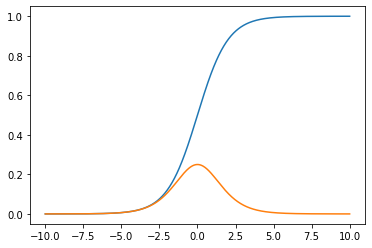

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x=np.linspace(-10,10,1000)
y=1/(1+np.exp(-x))
y1=np.exp(-x)/(1+np.exp(-x))**2
plt.plot(x,y,label='original')
plt.plot(x,y1,label='diff')
plt.show()

### 特点

- 易造成梯度消失（导数范围在$[0,0.25]$之间，多层链式求导导致导数值变小）
- 输出非0均值，收敛慢
- 幂运算复杂，训练时间长

### Tanh函数

$$
f(x)=\frac{1-e^{-2x}}{1+e^{-2x}}
$$

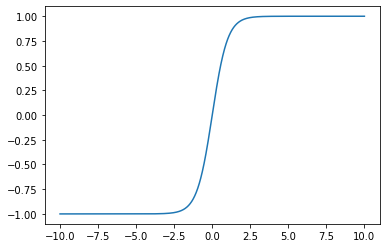

In [12]:
f=(1-np.exp(-2*x))/(1+np.exp(-2*x))
plt.plot(x,f)
plt.show()

### 特点

- 输出时0均值
- 易造成梯度消失
- 幂运算复杂

### Relu函数

$$
f(x)=\max(x,0)
$$

tf.nn.relu()

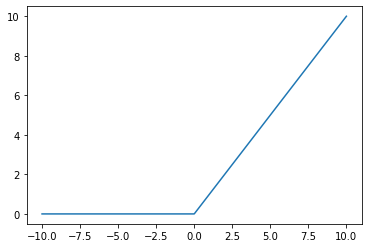

In [13]:
relu=x*(x>0)
plt.plot(x,relu)
plt.show()

### 优点

- 解决了梯度消失问题（在正区间）
- 只需要判断是否大于0，计算速度快
- 收敛速度快于sigmoid和tanh

### 缺点

- 输出非0均值，收敛满
- 某些神经元可能永远不会被激活，参数永远不能被更新

### Leaky Relu函数

$$
f(x)=\max(\alpha x,x)
$$

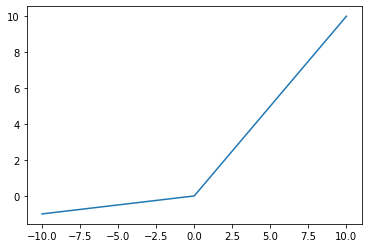

In [15]:
alpha=0.1
leaky_relu=alpha*x*(x<0)+x*(x>0)
plt.plot(x,leaky_relu)
plt.show()

从理论上讲，Leaky Relu有Relu的所有优点，外加不会有Dead Relu问题，并没有完全证明Leaky Relu总是好于Relu

### 对于初学者（我）的建议

- 首选Relu激活函数
- 学习率设置较小值
- 输入特征标准化，让输入特征满足以0为均值，1为标准差的正态分布
- 初始参数中心化，即让随机生成的参数满足以0为均值，$\sqrt{\frac{2}{\text{当前层输入特征个数}}}$为标准差的正态分布

# 损失函数

## 均方误差

设y是预测值，y_是已知答案
$$
MSE(y\_,y)=\frac{\sum_{i-1}^n(y-y\_)^2}{n}
$$
lose_mse=tf.reduce_mean(tf.square(y-y_))

## 自定义损失函数

有些情况预测多了和预测少了得到的损失不同，因此我们需要用分段函数来定义损失函数
$$
f(y\_,y)=\begin{cases}
profit*(y\_-y)&y<y\_\\
cost*(y-y\_)&y\geq y\_
\end{cases}
$$
loss_zdy=tf.reduce_sum(tf.where(tf.greater(y,y_),cost*(y-y_),profit*(y_-y)))

## 交叉熵损失函数CE（Cross Entropy）

表征两个概率分布之间的距离
$$
H(y\_,y)=-\sum y\_*\ln y
$$
tf.losses.categorical_crossentropy(y_,y)
<p> tf.nn.softmax_cross_entropy_with_logits(y_,y)
<p> 可先将y转化为softmax编码，然后求交叉熵

## 缓解过拟合

### 正则化缓解过拟合

正则化在损失函数中引入模型复杂度指标，给w加权值，弱化了训练数据的噪声
$$
loss=loss(y,y\_)+regularizer*loss(w)
$$
其中loss(w)需要进行正则化，
$$
loss_{L1}(w)=\sum_i|w_i|\\
loss_{L2}(w)=\sum_i|w_i^2|
$$
- L1正则化大概率会是很多参数变为零，通过稀疏参数，减少参数数量，降低复杂度
- L2正则化会使参数很接近零但不为零，通过减小参数的值的大小降低复杂度

代码：loss_regularization=[]
<p>loss_regularization.append(tf.nn.l2_loss(w1))
<p>loss_regularization.append(tf.nn.l2_loss(w2))
<p>loss_regularization=tf.reduce_sum(loss_regularization)
<p>loss=loss_mse+0.03*loss_regularization

In [2]:
import numpy as np

a=np.array([1,2,3,4])
b=lambda x:x**2
print(b(a))

[ 1  4  9 16]
